# 2D FEM with ACM element

![image](\img\door_drawing2.png)

In [38]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
from datetime import datetime
import os

pi = np.pi

In [39]:
h = 1.6e-3 # thickness [m]
H = 500e-3 # door height [m]
L = 200e-3 # door length [m]
Iz = (h**3)/12 # corss section moment of inertia per length [m**3]
E = 186e9 # modulus of elasticity [Pa]
nu = 0.3 # poison coef
rho = 7870 # steel density [kg/m**3]

def m_e(dx, dy):
    a=dx/2
    b=dy/2
    m11 =  np.array([[3454,	    922*b,	    -922*a,	    1226,	398*b,	    548*a       ],
                    [922*b,	    320*b**2,	-252*a*b,	398*b,	160*b**2,	168*a*b     ],
                    [-922*a,    -252*a*b,	320*a**2,	-548*a,	-168*a*b,	-240*a**2   ],
                    [1226,	    398*b,	    -548*a,	    3454,	922*b,	    922*a       ],
                    [398*b,	    160*b**2,	-168*a*b,	922*b,	320*b**2,	252*a*b     ],
                    [548*a,	    168*a*b,	-240*a**2,	922*a,	252*a*b,	320*a**2    ]])

    m21 =  np.array([[394,	    323*b,	    -232*a,	    1226,	548*b,	    398*a       ],
                    [-232*b,	-120*b**2,	112*a*b,	-548*b,	-240*b**2,	-168*a*b    ],
                    [232*a,	    112*a*b,	-120*a**2,	398*a,	168*a*b,	160*a**2    ],
                    [1226,	    548*b,	    -398*a,	    394,	232*b,	    232*a       ],
                    [-548*b,	-240*b**2,	168*a*b,	-232*b,	-120*b**2,	-112*a*b    ],
                    [-398*a,	-168*a*b,	160*a**2,	-232*a,	-112*a*b,	-120*a**2   ]])
    
    m22 =   np.array([[3454,	-922*b,	    922*a,	    1226,	-398*b,	    -548*a      ],
                    [-922*b,	320*b**2,	-252*a*b,	-398*b,	160*b**2,	168*a*b     ],
                    [922*a,	    -252*a*b,	320*a**2,	548*a,	-168*a*b,	-240*a**2   ],
                    [1226,	    -398*b,	    548*a,	    3454,	-922*b,	    -922*a      ],
                    [-398*b,	160*b**2,	-168*a*b,	-922*b,	320*b**2,	252*a*b     ],
                    [-548*a,	168*a*b,	-240*a**2,	-922*a,	252*a*b,	320*a**2    ]])

    m = np.concatenate((np.concatenate((m11, m21.T), axis=1),  np.concatenate((m21, m22), axis=1)), axis=0)

    return (rho*h*a*b/6300)*m

def k_e(dx, dy):
    a=dx/2
    b=dy/2
    alp=a/b
    bet=b/a
    I1 = np.eye(3)
    I1[0,0]=-1
    I2 = np.eye(3)
    I2[1,1]=-1
    I3 = np.eye(3)
    I3[2,2]=-1

    k11 = np.array([[4*(bet**2+alp**2)+0.4*(7-2*nu),	    2*(2*alp**2+0.2*(1+4*nu))*b,	    2*(-2*bet**2-0.2*(1+4*nu))*a    ],
                    [2*(2*alp**2+0.2*(1+4*nu))*b,	        4*(4/3*alp**2+4/15*(1-nu))*b**2,	-4*nu*a*b                       ],
                    [2*(-2*bet**2-0.2*(1+4*nu))*a,	        -4*nu*a*b,                      	4*(4/3*bet**2+4/15*(1-nu))*a**2]])

    k21 = np.array([[-(2*(2*bet**2-alp**2)+0.4*(7-2*nu)),	2*(alp**2-0.2*(1+4*nu))*b,	        2*(2*bet**2+0.2*(1-nu))*a     ],
                    [2*(alp**2-0.2*(1+4*nu))*b,	            4*(2/3*alp**2-4/15*(1-nu))*b**2,    0                               ],
                    [-2*(2*bet**2+0.2*(1-nu))*a,	        0,                          	    4*(2/3*bet**2-1/15*(1-nu))*a**2]])

    k31 = np.array([[-(2*(bet**2+alp**2)-0.4*(7-2*nu)),	    2*(-alp**2+0.2*(1-nu))*b,	        2*(bet**2-0.2*(1-nu))*a      ],
                    [2*(alp**2-0.2*(1-nu))*b,	            4*(1/3*alp**2+1/15*(1-nu))*b**2,	0                               ],
                    [2*(-bet**2+0.2*(1-nu))*a,	            0,	                                4*(1/3*bet**2+1/15*(1-nu))*a**2]])

    k41 = np.array([[2*(bet**2-2*alp**2)-0.4*(7-2*nu),	    2*(-2*alp**2-0.2*(1-nu))*b,	        2*(-bet**2+0.2*(1+4*nu))*a      ],
                    [2*(2*alp**2+0.2*(1-nu))*b,	            4*(2/3*alp**2-1/15*(1-nu))*b**2,	0                               ],
                    [2*(-bet**2+0.2*(1+4*nu))*a,	        0,	                                4*(2/3*bet**2-4/15*(1-nu))*a**2]])

    k22 = I3.T @ k11 @ I3
    k32 = I3.T @ k41 @ I3
    k42 = I3.T @ k31 @ I3
    
    k33 = I1.T @ k11 @ I1
    k43 = I1.T @ k21 @ I1

    k44 = I2.T @ k11 @ I2

    aux1 = np.concatenate((k11, k21.T, k31.T, k41.T), axis=1)
    aux2 = np.concatenate((k21, k22, k32.T, k42.T), axis=1)
    aux3 = np.concatenate((k31, k32, k33, k43.T), axis=1)
    aux4 = np.concatenate((k41, k42, k43, k44), axis=1)
    k = np.concatenate((aux1, aux2, aux3, aux4), axis=0)

    
    return E*h**3/(48*(1-nu**2)*a*b)*k

# Mesh Definition

In [40]:
# Node coordinates
# 2D rectangular plate, square ACM elements
eSize = 0.01/2 # meters
nElementX = int(L/eSize)
nElementY = int(H/eSize)
nElements = nElementX * nElementY
dx = L / nElementX
dy = H / nElementY
nNodesX = nElementX + 1
nNodesY = nElementY + 1
nNodes = nNodesX * nNodesY
ndof = nNodes*3

# Degrees of Freedom
# Define the number of each DoF for each node
node_dof = np.arange(1, 3*nNodes+1).reshape((nNodes, 3))
node_dof = pd.DataFrame(columns=["w", "thetaX", "thetaY"], index=np.arange(1, nNodes+1), data=node_dof, dtype=int)
node_dof.index.rename("Node", inplace=True)
node_dof.rename_axis("DoF", axis="columns", inplace=True)

# Nodes coordinates
node_coor = np.zeros((nNodes, 2))
for n in range(1, nNodes+1):
    q, r = divmod(n-1, nNodesX) # quotient and remainder
    node_coor[n-1, 0] = r*dx
    node_coor[n-1, 1] = q*dy

node_coor = pd.DataFrame(columns=["x", "y"], index=np.arange(1, nNodes+1), data=node_coor)
node_coor.index.rename("Node", inplace=True)
node_coor.rename_axis("Coordinate", axis="columns", inplace=True)

# Conectivity matrix
# Relates local nodes of elements to global nodes
element_con = np.zeros((nElements, 4))
for n in range(1, nElements+1):
    q, r = divmod(n, nElementX) # quotient and remainder
    if r == 0:
        q = q-1
        r = nElementX
    a = q*nNodesX + r
    element_con[n-1, 0] = a
    element_con[n-1, 1] = a + 1
    element_con[n-1, 2] = a + nNodesX + 1
    element_con[n-1, 3] = a + nNodesX

element_con = pd.DataFrame(columns=["1", "2", "3", "4"], index=np.arange(1, nElements+1), data=element_con, dtype=int)
element_con.index.rename("Element", inplace=True)
element_con.rename_axis("Local Node", axis="columns", inplace=True)

# Index table
# Relates the gloobal DoF associated with each element
index_table = np.zeros((nElements, 12))
for n in range(1, nElements+1):
    index_table[n-1, 0] = node_dof["w"][element_con["1"][n]] # w, local node 1
    index_table[n-1, 1] = node_dof["thetaX"][element_con["1"][n]] # thetaX, local node 1
    index_table[n-1, 2] = node_dof["thetaY"][element_con["1"][n]] # thetaY, locasl node 1

    index_table[n-1, 3] = node_dof["w"][element_con["2"][n]] # w, local node 2
    index_table[n-1, 4] = node_dof["thetaX"][element_con["2"][n]] # thetaX, local node 2
    index_table[n-1, 5] = node_dof["thetaY"][element_con["2"][n]] # thetaY, locasl node 2

    index_table[n-1, 6] = node_dof["w"][element_con["3"][n]] # w, local node 3
    index_table[n-1, 7] = node_dof["thetaX"][element_con["3"][n]] # thetaX, local node 3
    index_table[n-1, 8] = node_dof["thetaY"][element_con["3"][n]] # thetaY, locasl node 3

    index_table[n-1, 9] = node_dof["w"][element_con["4"][n]] # w, local node 4
    index_table[n-1, 10] = node_dof["thetaX"][element_con["4"][n]] # thetaX, local node 4
    index_table[n-1, 11] = node_dof["thetaY"][element_con["4"][n]] # thetaY, locasl node 4

col = pd.MultiIndex.from_arrays([["Local Node 1"]*3+ ["Local Node 2"]*3+ ["Local Node 3"]*3+ ["Local Node 4"]*3,
                                ["w", "thetaX", "thetaY"]*4])
index_table = pd.DataFrame(columns=col, index=np.arange(1, nElements+1), data=index_table, dtype=int)
index_table.index.rename("Element", inplace=True)

In [41]:
node_dof

DoF,w,thetaX,thetaY
Node,,,
1,1,2,3
2,4,5,6
3,7,8,9
4,10,11,12
5,13,14,15
...,...,...,...
4137,12409,12410,12411
4138,12412,12413,12414
4139,12415,12416,12417


In [42]:
element_con

Local Node,1,2,3,4
Element,,,,
1,1,2,43,42
2,2,3,44,43
3,3,4,45,44
4,4,5,46,45
5,5,6,47,46
...,...,...,...,...
3996,4095,4096,4137,4136
3997,4096,4097,4138,4137
3998,4097,4098,4139,4138


In [43]:
index_table

Local Node 1               Local Node 2               Local Node 3  \
                   w thetaX thetaY            w thetaX thetaY            w   
Element                                                                      
1                  1      2      3            4      5      6          127   
2                  4      5      6            7      8      9          130   
3                  7      8      9           10     11     12          133   
4                 10     11     12           13     14     15          136   
5                 13     14     15           16     17     18          139   
...              ...    ...    ...          ...    ...    ...          ...   
3996           12283  12284  12285        12286  12287  12288        12409   
3997           12286  12287  12288        12289  12290  12291        12412   
3998           12289  12290  12291        12292  12293  12294        12415   
3999           12292  12293  12294        12295  12296  12297        12418   
4000           12295  12296  12297        12298  12299  12300        12421   

                      Local Node 4                
        thetaX thetaY            w thetaX thetaY  
Element                                           
1          128    129          124    125    126  
2          131    132          127    128    129  
3          134    135          130    131    132  
4          137    138          133    134    135  
5          140    141          136    137    138  
...        ...    ...          ...    ...    ...  
3996     12410  12411        12406  12407  12408  
3997     12413  12414        12409  12410  12411  
3998     12416  12417        12412  12413  12414  
3999     12419  12420        12415  12416  12417  
4000     12422  12423        12418  12419  12420  

[4000 rows x 12 columns]

# Assembly of [K] and [M]

In [44]:
start_assy = datetime.now()
K = np.zeros((ndof,ndof))
M = np.zeros((ndof,ndof))

Ke = k_e(dx, dy)
Me = m_e(dx, dy)
for n in range(1, nElements+1):
    idx = index_table.loc[n].to_list()
    for i, p in enumerate(idx):
        for j, q in enumerate(idx):
            M[p-1,q-1] += Me[i, j]
            K[p-1,q-1] += Ke[i, j]
            
finish_assy = datetime.now()
print("Elapsed time: ", finish_assy - start_assy)
print("Stiffness matrix shape: ", K.shape)

Elapsed time:  0:00:01.051551
Stiffness matrix shape:  (12423, 12423)


# Find nodes inside BC regions and remove fixed DoF from [K] and [M]

In [45]:
start_bc = datetime.now()
# Fixed boundary conditions: Two points rectangle
region1 = np.array([[0.000, 0.100], [0.010, 0.120]])
region2 = np.array([[0.000, 0.380], [0.010, 0.400]])
region3 = np.array([[0.180, 0.240], [0.200, 0.280]])
regions = {1: region1, 2: region2, 3: region3}

fixed_dof = list()
fixed_nodes = list()
for r in regions.values():
    fixed_nodes += node_coor[(node_coor['x'].between(r[0][0], r[1][0])) & (node_coor['y'].between(r[0][1], r[1][1]))].index.tolist()

for node in fixed_nodes: 
    fixed_dof += node_dof.loc[node].tolist()

fixed_dof = np.array(fixed_dof)
idx = fixed_dof.argsort()# Ordering the fixed DoF to removem from [K] and [M]
fixed_dof = fixed_dof[idx]

# Removing fixed DoF from [K] and [M]
M = np.delete(M, fixed_dof - 1, axis=1)
M = np.delete(M, fixed_dof - 1, axis=0)
K = np.delete(K, fixed_dof - 1, axis=1)
K = np.delete(K, fixed_dof - 1, axis=0)

finish_bc = datetime.now()
print("Elapsed time: ", finish_bc - start_bc)

Elapsed time:  0:00:10.106867


# Plot nodes

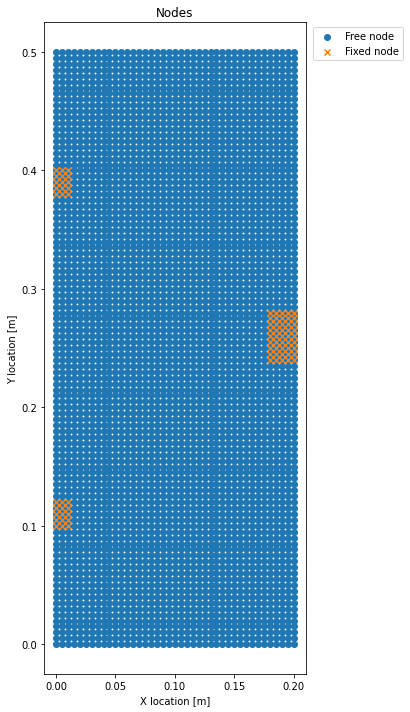

In [46]:
plt.figure(figsize=(30/5,50/5))
plt.scatter(x=node_coor['x'], y=node_coor['y'], label="Free node")
plt.scatter(x=node_coor['x'][fixed_nodes], y=node_coor['y'][fixed_nodes], marker='x', label='Fixed node')
plt.title("Nodes")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
plt.xlabel("X location [m]")
plt.ylabel("Y location [m]")
plt.tight_layout()
plt.savefig("img/nodes_free_and_fixed.pdf")
plt.show()

# Solve eignevalue problem

In [47]:
start_eig = datetime.now()
results = dict()

# Make [M] and [K] into an sparse matrix object
M = sp.sparse.bsr_matrix(M)
K = sp.sparse.bsr_matrix(K)

## Generalized eigenvalue problem. W is a 1D ndarray and Vc is a 2D ndarray with columns normalized to 1
# Sove the sparse eig problem using using shift-invert mode
# looking for the largest shifted eigenvalues (smalest original ones)
W, Vc = eigsh(A=K, k=40, M=M, which='LM', sigma=0, mode='normal')

# Ordering eigenvalues and the eigenvectors matrix
idx = W.argsort()
W = W[idx]
Vc = Vc[:,idx]
Vc_backup = Vc.copy()

# Normalizing eigenvectors matrix by the mass matrix, such that Vc.T @ M @ Vc = I
m_r = np.diagonal(Vc.T @ M @ Vc)
m_r = np.reciprocal(np.sqrt(m_r))
for a in range(Vc.shape[1]):
    Vc[:,a] *= m_r[a] # multiply every column by the scale factor
    
## Assembling the mode shapes
# Inserting the restricted DoF from the boundary conditions
for c in fixed_dof:
    Vc = np.insert(Vc, c-1, 0, axis=0)

results['fn'] = (W**0.5/(2*pi)).real
results['V'] = Vc[0::3, :].real # Displacement shape (dof 1,4,7,10,13,...) 
results['theta'] = np.delete(Vc, np.arange(0, Vc.shape[1]-1, 4), axis = 1).real # Angular shapes (dof 2,3,5,6,8,9,11,12,...)

# Make the mode shapes have the same orientation to be able to compare between different elements size used
for j in range(1, W.size):
    if np.sum(results['V'][:,j-1]) >= 0:
        pass
    else:
        results['V'][:,j-1] *= -1

finish_eig = datetime.now()
print("Elapsed time: ", finish_eig - start_eig)

Elapsed time:  0:00:07.875611


# Print mode frequencies

In [48]:
pd.options.display.float_format = "{:.2f}".format
df = pd.DataFrame(data=[results['fn']], index=[f"n={nElements}"], columns=[f"f_{j}" for j in range(1, len(results['fn'])+1)])
df

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40
n=4000,42.60,45.42,115.45,122.93,127.71,178.12,192.65,251.89,259.43,310.66,...,1137.26,1174.04,1185.74,1227.21,1258.24,1305.26,1335.14,1377.13,1458.16,1488.99


In [49]:
print(df.iloc[:,0:10].to_latex(na_rep="-"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &   f\_1 &   f\_2 &    f\_3 &    f\_4 &    f\_5 &    f\_6 &    f\_7 &    f\_8 &    f\_9 &   f\_10 \\
\midrule
n=4000 & 42.60 & 45.42 & 115.45 & 122.93 & 127.71 & 178.12 & 192.65 & 251.89 & 259.43 & 310.66 \\
\bottomrule
\end{tabular}



# Plot mode shapes

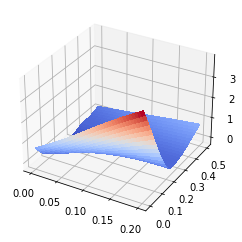

In [50]:
mode1 = results['V'][:,0].reshape((nNodesY, nNodesX))

x = np.linspace(0, L, nNodesX)
y = np.linspace(0, H, nNodesY)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, mode1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [51]:
z_data = pd.DataFrame(results['V'][:,0].reshape((nNodesY, nNodesX)))

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='First mode shape', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

# Calculate Accelerance

In [108]:
def A(U, W, j=1, k=1, f=np.arange(10,502,2), eta=0.03):
    """
    U (ndarray): mode shapes matrix [m]
    W (ndarray): natural frequencies vector [Hz]
    """
    A_jk = np.zeros(len(f), dtype=complex)
    for p, f in enumerate(f):
        for n, fn in enumerate(W):
            A_jk[p] += (-f**2)*U[j,n]*U[k,n]/(fn**2 - f**2 + 1j*eta*fn**2)

    return A_jk, omega

In [103]:
# Find nearest node within tolerance
r = np.array([0.150, 0.400])

tol = np.sqrt(dx*dy)/2 # tolerance
response_node = node_coor[(node_coor['x'].between(r[0]-tol, r[0]+tol)) & (node_coor['y'].between(r[1]-tol, r[1]+tol))].index.tolist()
response_node = response_node[0]
print("Node coordinates: ", node_coor.loc[response_node], "\nNode number: ", response_node)

Node coordinates:  Coordinate
x   0.15
y   0.40
Name: 3311, dtype: float64 
Node number:  3311


# Get Ansys results

In [105]:
path = r"D:\git_repos\Master_program_UFSC\VA\work2\ansys_results"

ansys_fn = np.loadtxt(path+"/eigenvalues.txt", delimiter="\t", usecols=2, skiprows=1)
ansys = pd.DataFrame(columns=['Mode','Node',"x","y","z"])

for file in os.listdir(path):
    if "mode_" in file:
        aux = pd.read_csv(path+"/"+ file, sep="\t", skiprows=1, names=['Node',"x","y","z"] )
        aux.insert(0,"Mode", [int(file[5:7])])
        ansys = ansys.append(aux)
    # print(int(file[5:7]))
ansys.set_index("Mode", inplace=True)
ansys["fn"] = ansys_fn.T

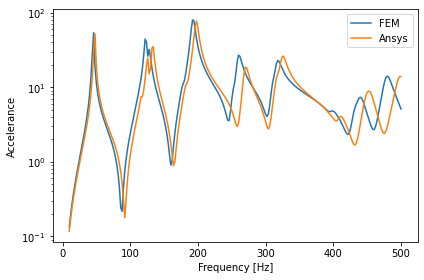

In [113]:
A_jk, f = A(results['V'], results['fn'], j=response_node, k=response_node)

plt.plot(f, np.abs(A_jk), label="FEM")
plt.yscale('log')

A_jk_ansys, f = A(np.array(ansys['z']).reshape((1,-1)), np.array(ansys['fn']), j=0, k=0)

plt.plot(f, np.abs(A_jk_ansys), label="Ansys")
plt.yscale('log')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Accelerance")
plt.tight_layout()
plt.show()
